In [108]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

# Helper for outlier capping
def cap_series(s, q=0.99):
    upper = s.quantile(q)
    return np.minimum(s, upper)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
!pip install pandas matplotlib


In [110]:
BASE = '/content/drive/MyDrive/data_feature/data/'

# 1) Orders + parse dates
orders = (
    pd.read_csv(BASE+'cleaned_orders.csv')
      .assign(
         purchase_dt=lambda df: pd.to_datetime(df['order_purchase_timestamp']),
         delivered_dt=lambda df: pd.to_datetime(df['order_delivered_customer_date']),
         est_dt=lambda df: pd.to_datetime(df['order_estimated_delivery_date'])
      )
      .drop(columns=[
         'order_purchase_timestamp',
         'order_delivered_customer_date',
         'order_estimated_delivery_date'
      ])
)

# 2) Payments → order-level value
payments = pd.read_csv(BASE+'cleaned_order_payments.csv')
order_vals = (
    payments
      .groupby('order_id')['payment_value']
      .sum()
      .rename('order_value')
      .to_frame()
)

# 3) Reviews (will merge customer_id later)
reviews = (
    pd.read_csv(BASE+'cleaned_order_reviews.csv')
      .assign(review_dt=lambda df: pd.to_datetime(df['review_creation_date']))
      .drop(columns=['review_creation_date'])
)


<ipython-input-110-4c847f0d971b>:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  .assign(review_dt=lambda df: pd.to_datetime(df['review_creation_date']))


In [111]:
# merge order_value into orders
orders = orders.merge(order_vals, on='order_id', how='left')

# delivery lag in days
orders['delivery_lag'] = (orders['delivered_dt'] - orders['purchase_dt']).dt.days

# on-time flag
orders['on_time'] = (orders['delivered_dt'] <= orders['est_dt']).astype(int)

# previous purchase & days_between
orders = orders.sort_values(['customer_id','purchase_dt'])
orders['prev_purchase'] = orders.groupby('customer_id')['purchase_dt'].shift()
orders['days_between']  = (orders['purchase_dt'] - orders['prev_purchase']).dt.days


In [112]:
REF_DATE     = orders['purchase_dt'].max()
WINDOW_MONTHS = 6

mask_window = (
    (orders['purchase_dt'] >= REF_DATE - pd.DateOffset(months=WINDOW_MONTHS)) &
    (orders['purchase_dt'] <= REF_DATE)
)
orders_win = orders[mask_window]


In [113]:
print(orders_win.columns.tolist())


['order_id', 'customer_id', 'order_status', 'order_approved_at', 'order_delivered_carrier_date', 'purchase_dt', 'delivered_dt', 'est_dt', 'order_value', 'delivery_lag', 'on_time', 'prev_purchase', 'days_between']


In [114]:
# ── New Preprocessing Cell ──

# 1) Merge in order_value
orders = orders.merge(order_vals, on='order_id', how='left')

# 2) Compute delivery lag (days) and on‐time flag
orders['delivery_lag'] = (orders['delivered_dt'] - orders['purchase_dt']).dt.days
orders['on_time']      = (orders['delivered_dt'] <= orders['est_dt']).astype(int)

# 3) Compute days between consecutive purchases
orders = orders.sort_values(['customer_id','purchase_dt'])
orders['prev_purchase'] = orders.groupby('customer_id')['purchase_dt'].shift()
orders['days_between']  = (orders['purchase_dt'] - orders['prev_purchase']).dt.days

# 4) Re-define the 6-month window
REF_DATE     = orders['purchase_dt'].max()
WINDOW_MONTHS = 6
mask_window  = (
    (orders['purchase_dt'] >= REF_DATE - pd.DateOffset(months=WINDOW_MONTHS)) &
    (orders['purchase_dt'] <= REF_DATE)
)
orders_win = orders[mask_window]

# 5) Quick sanity check
print("Columns now in orders_win:", orders_win.columns.tolist())


Columns now in orders_win: ['order_id', 'customer_id', 'order_status', 'order_approved_at', 'order_delivered_carrier_date', 'purchase_dt', 'delivered_dt', 'est_dt', 'order_value_x', 'delivery_lag', 'on_time', 'prev_purchase', 'days_between', 'order_value_y']


In [115]:
# Cell 5 – Aggregate RFM & Behavioral Features

# 5a) If needed, merge in order_value from payments
if 'order_value' not in orders_win.columns:
    order_vals = (
        payments
          .groupby('order_id')['payment_value']
          .sum()
          .reset_index(name='order_value')
    )
    orders_win = orders_win.merge(order_vals, on='order_id', how='left')

# 5b) Group and aggregate
rfm_beh = (
    orders_win
      .groupby('customer_id')
      .agg(
        order_count    = ('order_id',    'nunique'),
        total_spend    = ('order_value', 'sum'),
        avg_order_val  = ('order_value', 'mean'),
        avg_days_btwn  = ('days_between','mean'),
        on_time_ratio  = ('on_time',     'mean'),
        mean_lag       = ('delivery_lag','mean'),
        std_lag        = ('delivery_lag','std')
      )
      .reset_index()
)

# 5c) Add recency (days since last purchase)
last_purch = orders.groupby('customer_id')['purchase_dt'].max()
rfm_beh['recency_days'] = (
    REF_DATE - rfm_beh['customer_id'].map(last_purch)
).dt.days

rfm_beh.head()


,customer_id,order_count,total_spend,avg_order_val,avg_days_btwn,on_time_ratio,mean_lag,std_lag,recency_days
0,000598caf2ef4117407665ac33275130,1,1255.71,1255.71,NaN,1.0,9.0,NaN,67
1,0005aefbb696d34b3424dccd0a0e9fd0,1,147.33,147.33,NaN,1.0,2.0,NaN,119
2,001051abfcfdbed9f87b4266213a5df1,1,65.20,65.20,NaN,1.0,5.0,NaN,140
3,0013cd8e350a7cc76873441e431dd5ee,1,92.60,92.60,NaN,1.0,4.0,NaN,162
4,0015bc9fd2d5395446143e8b215d7c75,1,132.19,132.19,NaN,1.0,2.0,NaN,127


In [116]:
# Cell 6 – Pull in Review Features

rev = (
    reviews
      .merge(orders[['order_id','customer_id']], on='order_id', how='left')
      .groupby('customer_id')['review_score']
      .agg(avg_review_score='mean', review_count='count')
      .reset_index()
)

rev.head()


,customer_id,avg_review_score,review_count
0,00012a2ce6f8dcda20d059ce98491703,1.0,1
1,000161a058600d5901f007fab4c27140,4.0,1
2,0001fd6190edaaf884bcaf3d49edf079,5.0,1
3,0002414f95344307404f0ace7a26f1d5,5.0,1
4,000379cdec625522490c315e70c7a9fb,4.0,1


In [117]:
# Cell 7 – Join & Finalize Feature Table

features = rfm_beh.merge(rev, on='customer_id', how='left')

# Fill customers with no reviews
features[['avg_review_score','review_count']] = features[
    ['avg_review_score','review_count']
].fillna(0)

# Reorder columns for clarity
cols = [
  'customer_id','order_count','recency_days','total_spend','avg_order_val',
  'avg_days_btwn','on_time_ratio','mean_lag','std_lag',
  'avg_review_score','review_count'
]
features = features[cols]

features.head()


,customer_id,order_count,recency_days,total_spend,avg_order_val,avg_days_btwn,on_time_ratio,mean_lag,std_lag,avg_review_score,review_count
0,000598caf2ef4117407665ac33275130,1,67,1255.71,1255.71,NaN,1.0,9.0,NaN,5.0,1.0
1,0005aefbb696d34b3424dccd0a0e9fd0,1,119,147.33,147.33,NaN,1.0,2.0,NaN,4.0,1.0
2,001051abfcfdbed9f87b4266213a5df1,1,140,65.20,65.20,NaN,1.0,5.0,NaN,4.0,1.0
3,0013cd8e350a7cc76873441e431dd5ee,1,162,92.60,92.60,NaN,1.0,4.0,NaN,5.0,1.0
4,0015bc9fd2d5395446143e8b215d7c75,1,127,132.19,132.19,NaN,1.0,2.0,NaN,5.0,1.0


In [118]:
# Cell 8 – Cap, Log-Transform Skewed Features, Flag Single-Order & Impute avg_days_btwn

# 1) Cap & log1p-transform the skewed counts and spend
for c in ['order_count', 'total_spend', 'avg_order_val']:
    features[c] = cap_series(features[c], 0.99)
    features[f'log1p_{c}'] = np.log1p(features[c])

# 2) Flag single-order customers
features['single_order'] = (features['order_count'] == 1).astype(int)

# 3) Impute avg_days_btwn for single-order customers (and any others)
median_btwn = features['avg_days_btwn'].median()
features['avg_days_btwn'] = features['avg_days_btwn'].fillna(median_btwn)

# 4) Quick peek
features.head()


,customer_id,order_count,recency_days,total_spend,avg_order_val,avg_days_btwn,on_time_ratio,mean_lag,std_lag,avg_review_score,review_count,log1p_order_count,log1p_total_spend,log1p_avg_order_val,single_order
0,000598caf2ef4117407665ac33275130,1.0,67,1125.0023,1125.0023,NaN,1.0,9.0,NaN,5.0,1.0,0.693147,7.026429,7.026429,1
1,0005aefbb696d34b3424dccd0a0e9fd0,1.0,119,147.3300,147.3300,NaN,1.0,2.0,NaN,4.0,1.0,0.693147,4.999440,4.999440,1
2,001051abfcfdbed9f87b4266213a5df1,1.0,140,65.2000,65.2000,NaN,1.0,5.0,NaN,4.0,1.0,0.693147,4.192680,4.192680,1
3,0013cd8e350a7cc76873441e431dd5ee,1.0,162,92.6000,92.6000,NaN,1.0,4.0,NaN,5.0,1.0,0.693147,4.539030,4.539030,1
4,0015bc9fd2d5395446143e8b215d7c75,1.0,127,132.1900,132.1900,NaN,1.0,2.0,NaN,5.0,1.0,0.693147,4.891777,4.891777,1


In [119]:
# Cell 9 – Feature Scaling
from sklearn.compose      import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler

# a) Pick columns
std_feats    = ['order_count','recency_days','avg_days_btwn',
                'log1p_order_count','log1p_avg_order_val',
                'review_count','mean_lag','std_lag']
robust_feats = ['total_spend','avg_order_val']
# on_time_ratio stays in [0,1], so passthrough

# b) Build transformer
preprocessor = ColumnTransformer([
    ('std',    StandardScaler(), std_feats),
    ('robust', RobustScaler(),   robust_feats),
], remainder='passthrough')

# c) Fit/transform (drop customer_id)
to_transform = std_feats + robust_feats + ['on_time_ratio']
scaled_arr   = preprocessor.fit_transform(features[to_transform])

# d) Rebuild DataFrame
scaled_cols = [f"{c}_std"    for c in std_feats] + \
              [f"{c}_robust" for c in robust_feats] + \
              ['on_time_ratio']
scaled_df   = pd.DataFrame(scaled_arr,
                           columns=scaled_cols,
                           index=features.index)

# e) Merge back customer_id
features = pd.concat([features[['customer_id']], scaled_df], axis=1)
features.head()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


,customer_id,order_count_std,recency_days_std,avg_days_btwn_std,log1p_order_count_std,log1p_avg_order_val_std,review_count_std,mean_lag_std,std_lag_std,total_spend_robust,avg_order_val_robust,on_time_ratio
0,000598caf2ef4117407665ac33275130,0.0,-1.262999,NaN,0.0,2.897947,0.046812,-0.018037,NaN,8.749697,8.749697,1.0
1,0005aefbb696d34b3424dccd0a0e9fd0,0.0,0.058237,NaN,0.0,0.354381,0.046812,-1.054082,NaN,0.336718,0.336718,1.0
2,001051abfcfdbed9f87b4266213a5df1,0.0,0.591814,NaN,0.0,-0.657980,0.046812,-0.610063,NaN,-0.370020,-0.370020,1.0
3,0013cd8e350a7cc76873441e431dd5ee,0.0,1.150798,NaN,0.0,-0.223363,0.046812,-0.758069,NaN,-0.134240,-0.134240,1.0
4,0015bc9fd2d5395446143e8b215d7c75,0.0,0.261505,NaN,0.0,0.219280,0.046812,-1.054082,NaN,0.206437,0.206437,1.0


In [120]:
# Cell 10 – Inspect & Save

print("Final feature table shape:", features.shape)
features.head()

# Export and download
features.to_csv('/content/customer_features.csv', index=False)
from google.colab import files
files.download('/content/customer_features.csv')


Final feature table shape: (28974, 12)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

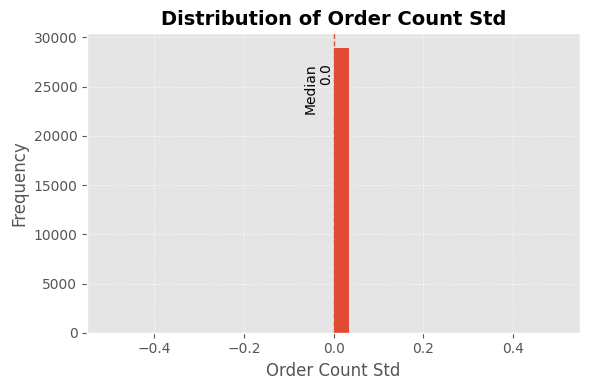

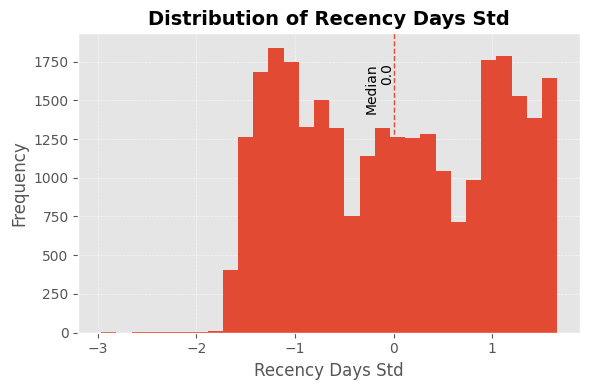

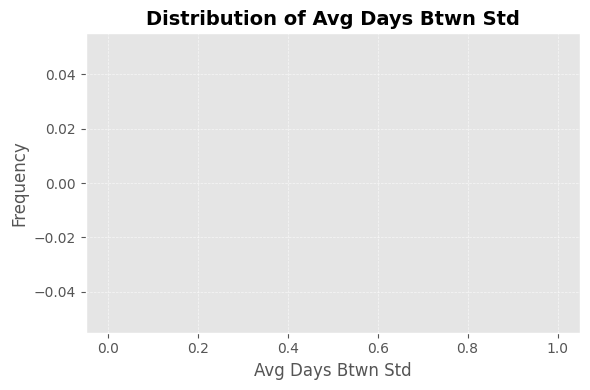

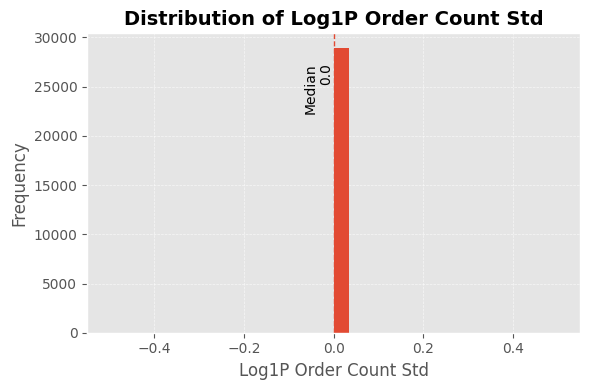

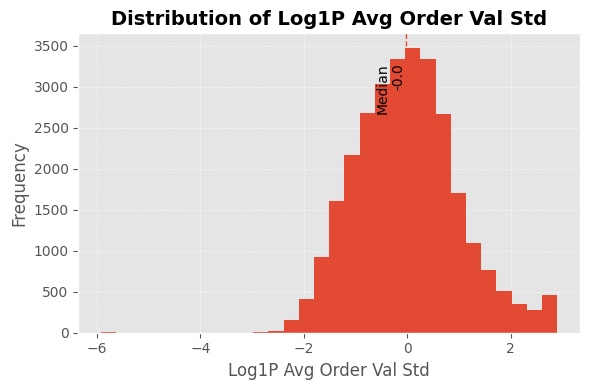

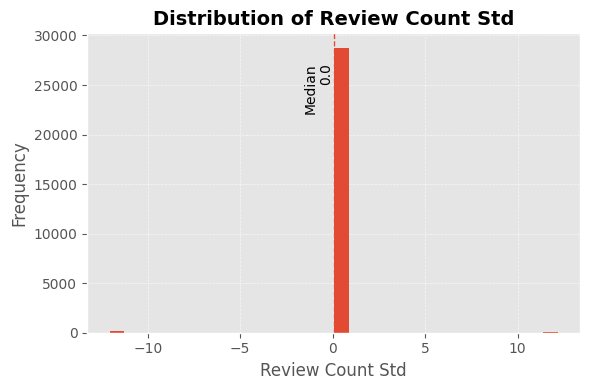

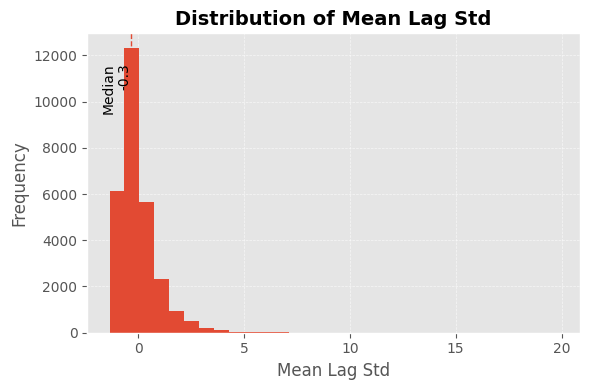

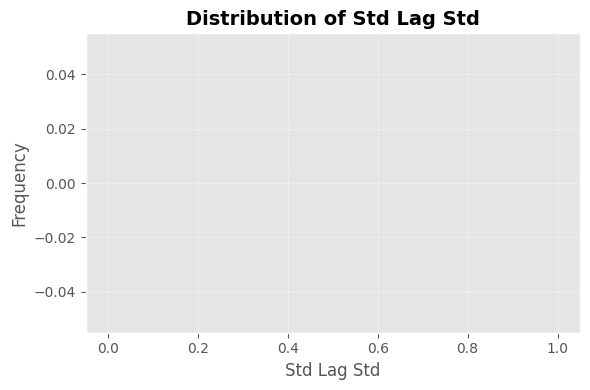

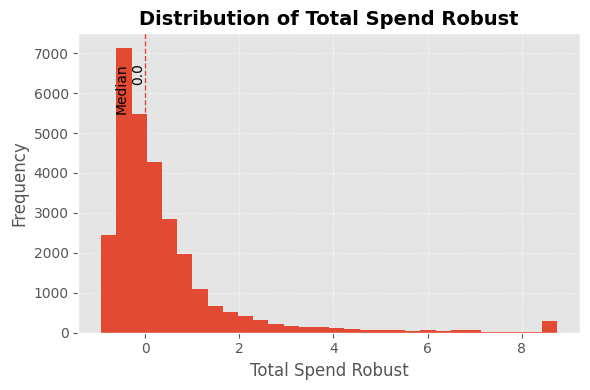

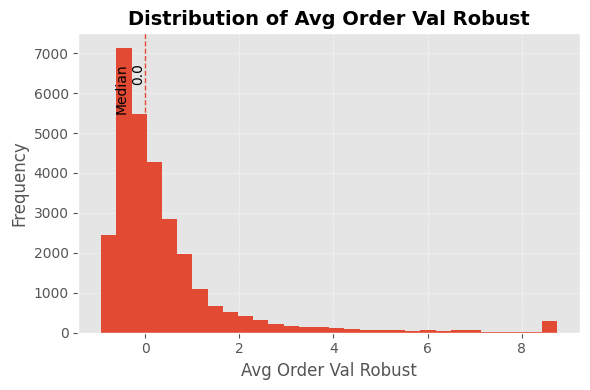

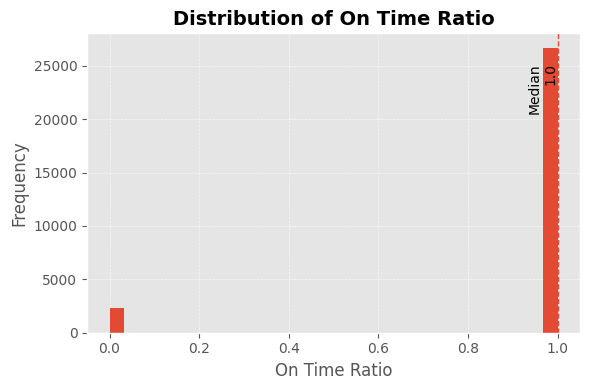

In [121]:
# Cell 11 – Improved Aesthetics for Distributions

plt.style.use('ggplot')

for col in features.columns:
    if col == 'customer_id':
        continue

    fig, ax = plt.subplots(figsize=(6,4))
    data = features[col].dropna()

    ax.hist(data, bins=30)
    med = data.median()
    ax.axvline(med, linestyle='--', linewidth=1)
    ax.text(med, ax.get_ylim()[1]*0.9, f"Median\n{med:.1f}",
            rotation=90, va='top', ha='right', fontsize=10)

    ax.set_title(f"Distribution of {col.replace('_',' ').title()}",
                 fontsize=14, fontweight='bold')
    ax.set_xlabel(col.replace('_',' ').title(), fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()


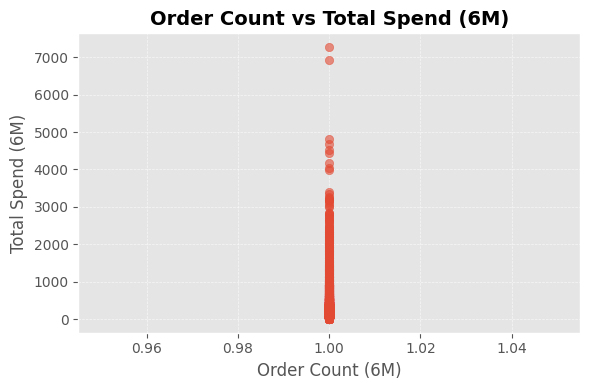

In [126]:
# Cell 12 – Scatter: Order Count vs Total Spend (raw)
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(6,4))

ax.scatter(
    rfm_beh['order_count'],
    rfm_beh['total_spend'],
    alpha=0.6
)

ax.set_title(
    'Order Count vs Total Spend (6M)',
    fontsize=14, fontweight='bold'
)
ax.set_xlabel('Order Count (6M)', fontsize=12)
ax.set_ylabel('Total Spend (6M)', fontsize=12)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

# # Cell 12 – Scatter: Scaled Order Count vs Robust Total Spend
# plt.style.use('ggplot')
# fig, ax = plt.subplots(figsize=(6,4))

# ax.scatter(
#     features['order_count_std'],
#     features['total_spend_robust'],
#     alpha=0.6
# )

# ax.set_title(
#     'Order Count (std) vs Total Spend (robust)',
#     fontsize=14, fontweight='bold'
# )
# ax.set_xlabel('Order Count (std)', fontsize=12)
# ax.set_ylabel('Total Spend (robust)', fontsize=12)
# ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# plt.tight_layout()
# plt.show()




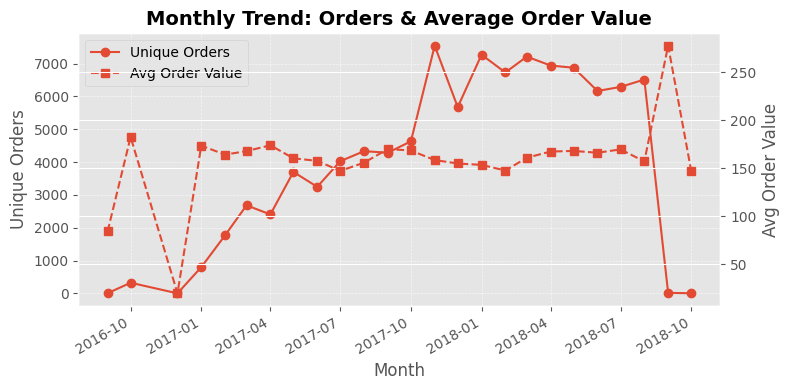

In [127]:
# Cell 13 – Line Graph: Monthly Orders & Avg Order Value

# make sure orders has order_value
if 'order_value' not in orders.columns:
    order_vals = payments.groupby('order_id')['payment_value'] \
                         .sum() \
                         .reset_index(name='order_value')
    orders = orders.merge(order_vals, on='order_id', how='left')

# extract month and aggregate
orders['month'] = orders['purchase_dt'].dt.to_period('M').dt.to_timestamp()
monthly = orders.groupby('month').agg(
    unique_orders = ('order_id','nunique'),
    avg_value     = ('order_value','mean')
)

plt.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()

# plot unique orders
ax1.plot(monthly.index, monthly['unique_orders'],
         marker='o', label='Unique Orders')
# plot avg order value
ax2.plot(monthly.index, monthly['avg_value'],
         linestyle='--', marker='s', label='Avg Order Value')

ax1.set_title('Monthly Trend: Orders & Average Order Value',
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Unique Orders', fontsize=12)
ax2.set_ylabel('Avg Order Value', fontsize=12)

# combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2, loc='upper left')

ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()
